Setup

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
DIRECTORY = "/content/drive/My Drive/cs231n/final project"
%cd $DIRECTORY

Mounted at /content/drive
/content/drive/My Drive/cs231n/final project


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import json

import numpy as np

from copy import deepcopy

import matplotlib.pyplot as plt

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cpu


Load data

In [ ]:
from ast import literal_eval

text_model = ""
image_model = "resnet-18"

# Load in data and unwrap it
# Function to convert stringified tuple keys back to tuples
def unwrap_keys(mapping):
    return {literal_eval(k): v for k, v in mapping.items()}

# Load the JSON file
with open(f'./embeddings/{image_model}_embeddings_raw_train_aug.json', 'r') as json_file:
    train_embeddings_from_json = json.load(json_file)

with open(f'./embeddings/{image_model}_embeddings_train_aug.json', 'r') as json_file:
    train_from_json = json.load(json_file)

# Load the JSON file
with open(f'./embeddings/{image_model}_embeddings_raw_val_aug.json', 'r') as json_file:
    val_embeddings_from_json = json.load(json_file)

with open(f'./embeddings/{image_model}_embeddings_val_aug.json', 'r') as json_file:
    val_from_json = json.load(json_file)

# Load the JSON file
with open(f'./embeddings/{image_model}_embeddings_raw_test_aug.json', 'r') as json_file:
    test_embeddings_from_json = json.load(json_file)

with open(f'./embeddings/{image_model}_embeddings_test_aug.json', 'r') as json_file:
    test_from_json = json.load(json_file)


# print(data_from_json)
# Unwrap the keys to their original tuple format
# embeddings_from_json = unwrap_keys(embeddings_from_json)
train_from_json = unwrap_keys(train_from_json)
val_from_json = unwrap_keys(val_from_json)
test_from_json = unwrap_keys(test_from_json)

In [ ]:
text_key = "text_embedding"
image_key = "image_embeddings_all"
# score_key = "scores"
image_embeddings_top_5 = "image_embeddings_top5_idx"
image_embedding_key = "image_embeddings_key"

def create_dataset(raw_json, train_json):
  image_embeddings = []
  text_embeddings = []
  y_output = []
  X_image_eval = []
  X_text_embed_eval = []
  y_eval = []
  prompts = []
  indeces = []
  index = 0
  for key, sub_dataset in train_json.items():
    # print(key)
    # if doing adverserial training
    if key[1] != 1:
      continue
    y_i = key[1]
    text_embedding = sub_dataset[text_key]
    # fix for clip embeddings
    # image_embedding = [item[0] for item in raw_json[sub_dataset[image_embedding_key]]]
    # regular
    image_embedding = raw_json[sub_dataset[image_embedding_key]]
    # scores = sub_dataset[score_key]
    top5 = sub_dataset[image_embeddings_top_5]
    idx = top5[0]
    # print(key, idx, len(image_embedding), index)
    indeces.append(idx)
    image_embeddings.append(image_embedding[idx])
    text_embeddings.append(text_embedding)
    y_output.append(y_i)
    index += 1
    if y_i == 1: #only add to evaluation set positive examples
      X_image_eval.append(image_embedding)
      X_text_embed_eval.append([text_embedding] * len(image_embedding))
      y_eval.append(top5)

  N = len(image_embeddings)
  print(len(image_embeddings), len(text_embeddings), len(y_output))
  return image_embeddings, text_embeddings, y_output, X_image_eval, X_text_embed_eval, y_eval, indeces
# print(y_output)


In [ ]:
train_images, train_text, train_y, train_whole_images, train_repeated_text, train_y_top, \
train_indeces = create_dataset(train_embeddings_from_json, train_from_json)
train_images = torch.tensor(train_images)
train_text = torch.tensor(train_text)
train_y = torch.tensor(train_y)
train_data = (train_images, train_text, train_y, train_whole_images, train_repeated_text, train_y_top, \
train_indeces)
_, _, _, eval_whole_images, eval_whole_text, eval_y, _ = create_dataset(val_embeddings_from_json, val_from_json)
eval_data = (eval_whole_images, eval_whole_text, eval_y)
_, _, _, test_whole_images, test_whole_text, test_y, _ = create_dataset(test_embeddings_from_json, test_from_json)
test_data = (test_whole_images, test_whole_text, test_y)

480 480 480
100 100 100
60 60 60


In [ ]:
print(train_images.shape, train_text.shape)

torch.Size([480, 1000]) torch.Size([480, 384])


In [ ]:
# if using non-adverserial training
dataset = TensorDataset(train_images, train_text, train_y)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model architecture and eval

In [ ]:
imageEmbeddingSize, queryTextEmbeddingSize = 1000, 384

In [ ]:
class EmbeddingProjectionNN(nn.Module):
    def __init__(self, embeddingSize):
      super().__init__()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(embeddingSize, 512),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(512, 512),
          nn.LayerNorm(512),
          nn.ReLU(),
          nn.Dropout(),
          nn.Linear(512, 256),
          nn.ReLU()
      )

    def forward(self, x):
      # input (N, E)
      projection = self.linear_relu_stack(x)
      return projection

class RetrieverNN(nn.Module):
  def __init__(self, imageEmbedding, queryEmbedding):
    super().__init__()
    self.imageProj = EmbeddingProjectionNN(imageEmbedding)
    self.queryProj = EmbeddingProjectionNN(queryEmbedding)
    # self.similarity = nn.CosineSimilarity(dim=1)


  def forward(self, images, query):
    imageProj = self.imageProj(images)
    queryProj = self.queryProj(query)
    # similarities = self.similarity(imageProj, queryProj)
    distances = torch.norm(imageProj - queryProj, dim=1) / torch.norm(torch.abs(imageProj) + torch.abs(queryProj), dim=1)
    # make similarities a prob scores between 0 and 1
    # scores = similarities * 0.5 + 0.5
    scores = 1 - distances
    return scores



In [ ]:
def eval_model(model, X_image_eval, X_text_eval, y_eval):
  #Evaluate model
  model.eval()  # set model to evaluation mode
  eval_loose = 0
  eval_tight = 0
  N = len(X_image_eval)
  with torch.no_grad():
    for i in range(N):
      X_image = torch.tensor(X_image_eval[i])
      X_query_eval = torch.tensor(X_text_eval[i])
      top5 = y_eval[i]
      probs = model(X_image, X_query_eval)
      top_pred = probs.detach().numpy().squeeze()
      # print(prompts[i])
      # print(top5[0], top_pred)
      pred_idx = np.argmax(top_pred)
      # print(top5[0], top_pred)
      if pred_idx in top5:
        eval_loose += 1
      if pred_idx == top5[0]:
        eval_tight += 1
  # print(f"tight: {eval_tight}, loose: {eval_loose}, N: {N}")
  return (float(eval_tight)/ N, float(eval_loose)/N)



Training

In [ ]:
reg_val_acc = []
loss = nn.BCELoss()
def train_part34(model, optimizer, model_name, eval_data, epochs=10, scheduler = None):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    eval_whole_images, eval_whole_text, eval_y = eval_data
    highest_accuracy = 0
    for e in range(epochs):
        for imageEmbeddings, queryEmbedding, y in dataloader:
          # (B, E1), (B, E2), (B,)
          model.train()  # put model to training mode
          imageEmbeddings = imageEmbeddings.to(device=device, dtype=dtype)  # move to device, e.g. GPU
          queryEmbedding = queryEmbedding.to(device=device, dtype=dtype)
          y = y.to(device=device, dtype=dtype)

          scores = model(imageEmbeddings, queryEmbedding)
          # print(scores)
          # print(y)
          output = loss(scores, y)
          # print(scores, y)

          # Zero out all of the gradients for the variables which the optimizer
          # will update.
          optimizer.zero_grad()

          # This is the backwards pass: compute the gradient of the loss with
          # respect to each  parameter of the model.
          output.backward()

          # Actually update the parameters of the model using the gradients
          # computed by the backwards pass.
          optimizer.step()
          if scheduler:
            scheduler.step()
          # print('Iteration %d, loss = %.4f' % (e, output.item()))

        eval_acc = eval_model(model, eval_whole_images, eval_whole_text, eval_y)
        # eval_acc = eval_model(model, train_whole_images, train_repeated_text, train_y_top)
        print('Iteration %d, loss = %.4f' % (e, output.item()))
        print('Iteration %d, 1_accuracy = %.4f, 5_accuracy = %.4f' % (e, eval_acc[0], eval_acc[1]))
        reg_val_acc.append(eval_acc[0])
        if highest_accuracy < eval_acc[0]:
          print("saving model!")
          highest_accuracy = eval_acc[0]
          torch.save(deepcopy(model.state_dict()), model_name)


Training with contrastive examples

In [ ]:
ad_val_acc = []
loss = nn.BCELoss()
ad_off_index = []
def train_part_contrastive(model, optimizer, model_name,
                           train_data, eval_data, epochs=10, scheduler = None):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    ad_off_index_local = []
    train_images, train_text, train_y, train_whole_images, train_repeated_text, train_y_top, \
    train_indeces = train_data
    N = train_images.shape[0]
    highest_accuracy = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    eval_whole_images, eval_whole_text, eval_y = eval_data

    for e in range(epochs):
      interval = 32
      for i in range(0, N, interval):
          # Get the current batch and train that batch
          image_batch = train_images[i:i + interval].to(device=device, dtype=dtype)
          query_batch = train_text[i:i + interval].to(device=device, dtype=dtype)
          y_batch = train_y[i:i + interval].to(device=device, dtype=dtype)
          index_batch = train_indeces[i:i + interval]
          model.train()  # put model to training mode
          scores = model(image_batch, query_batch)
          output = loss(scores, y_batch)
          optimizer.zero_grad()
          # output.backward()


          # find the best contrastive examples for each text prompt
          model.eval()
          eval_images = train_whole_images[i:i + interval]
          query_eval = train_repeated_text[i:i + interval]

          contrastive_images = torch.zeros(len(eval_images), imageEmbeddingSize)
          with torch.no_grad():
            for j in range(len(eval_images)):
              images_i = torch.tensor(eval_images[j]).to(device=device, dtype=dtype)
              queries_i = torch.tensor(query_eval[j]).to(device=device, dtype=dtype)
              probs = model(images_i, queries_i).detach().numpy().squeeze()
              sorted = np.argsort(probs)[::-1]
              # print(index_batch, j)
              correct = index_batch[j]
              worst_miss = None
              if sorted[0] != correct:
                worst_miss = sorted[0]
              else:
                worst_miss = sorted[1]

              contrastive_images[j] = images_i[worst_miss]

              if i + j == 186:
                ad_off_index_local.append(correct - worst_miss)
                # print(ad_off_index)
          # print(contrastive_images)
          # image_batch = torch.tensor(contrastive_images).to(device=device, dtype=dtype)
          y_batch = torch.zeros(len(eval_images))

          model.train()  # put model to training mode
          scores = model(contrastive_images, query_batch)
          output += loss(scores, y_batch)
          output.backward()

          optimizer.step()
          if scheduler:
            scheduler.step()
      eval_acc = eval_model(model, eval_whole_images, eval_whole_text, eval_y)
      # eval_acc = eval_model(model, train_whole_images, train_repeated_text, train_y_top)
      print('Iteration %d, loss = %.4f' % (e, output.item()))
      print('Iteration %d, 1_accuracy = %.4f, 5_accuracy = %.4f' % (e, eval_acc[0], eval_acc[1]))
      ad_val_acc.append(eval_acc[0])
      if highest_accuracy < eval_acc[0]:
        print("saving model!")
        highest_accuracy = eval_acc[0]
        torch.save(deepcopy(model.state_dict()), model_name)
    print(ad_off_index_local)
    ad_off_index = ad_off_index_local




New Data Format

In [ ]:
# train model
ad_val_acc = []
model_name = "0603_resnet18_adv_cos"
model = RetrieverNN(imageEmbeddingSize, queryTextEmbeddingSize)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_part_contrastive(model, optimizer, model_name, train_data, eval_data, epochs = 5)
# train_part34(model, optimizer, model_name, eval_data, epochs = 5)

In [ ]:
# load model back in
model = RetrieverNN(imageEmbeddingSize, queryTextEmbeddingSize)
model.load_state_dict(torch.load(model_name))
eval_model(model, test_whole_images, test_whole_text, test_y)

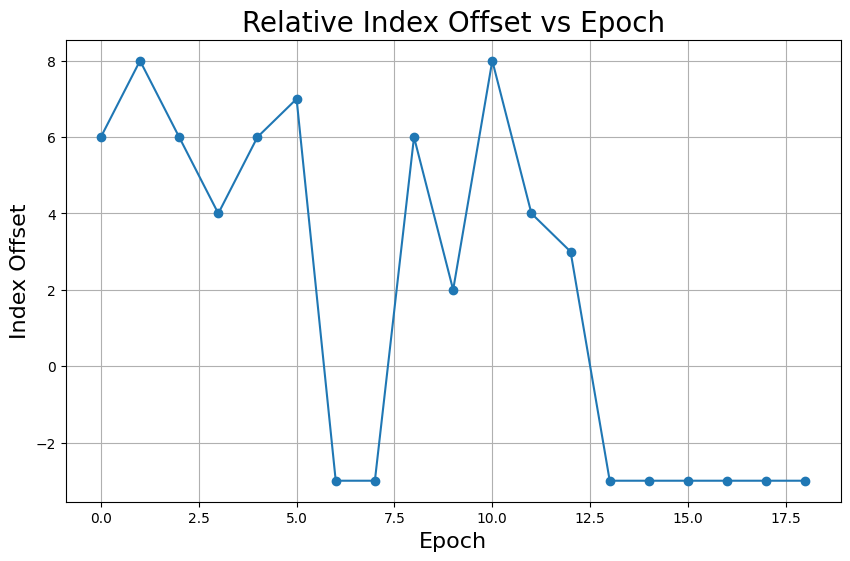

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot([6, 8, 6, 4, 6, 7, -3, -3, 6, 2, 8, 4, 3, -3, -3, -3, -3, -3, -3], marker='o', linestyle='-')
plt.title('Relative Index Offset vs Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Index Offset', fontsize = 16)
plt.grid(True)

plt.savefig("index offset figure.pdf")
plt.show()
